In [8]:
roots = dict(
    invivo_2x=dict(
        zf="../logs/ZF/3sjx9miz/medias",
        resunet_mim="../logs/RESUNET/1oqr6pzs/medias"
    ),
    invivo_4x=dict(
        zf="../logs/ZF/3i2f2bzm/medias",
        resunet_mim="../logs/RESUNET/o15o6j4c/medias"
    )
)

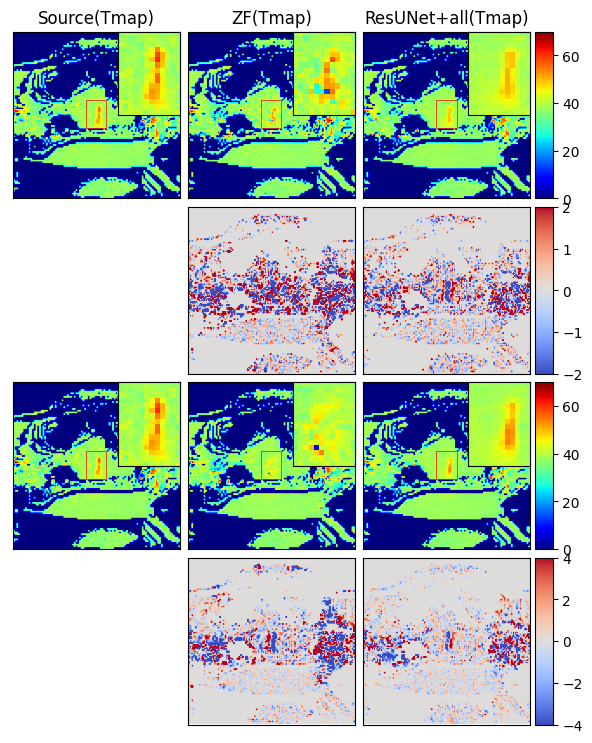

In [9]:
"""Compare Drawing Invivo ResUNet (Version 3)"""

import os
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from fastmrt.data.mask import EquiSpacedMaskFunc
import numpy as np
import matplotlib.pyplot as plt

dataset_types = {"invivo": "FastMRT Dataset V5.0_invivo"}
samples = {"invivo": "t13025.h5"}
frame_names = {"invivo": ["f08s0c0", "f08s0c0"]}
datas = {}
x_offset, y_offset, rate = 6, 8, 3


# obtain temperature maps
for key, val in roots.items():
    sub_data = {}
    dataset = key.split("_")[0]
    if dataset == "exvivo" or dataset == "phantom":
        continue
    for k, v in val.items():
        file_dir = os.path.join(v, f"{dataset_types[dataset]}_test_{samples[dataset]}_{frame_names[dataset][0]}")
        if os.path.exists(file_dir) is False:
            file_dir = os.path.join(v, f"{dataset_types[dataset]}_test_{samples[dataset]}_{frame_names[dataset][1]}")
        full_tmap = np.load(os.path.join(file_dir, "full_tmap.npy"))
        recon_tmap = np.load(os.path.join(file_dir, "recon_tmap.npy"))
        label = np.load(os.path.join(file_dir, "label.npy"))
        output = np.load(os.path.join(file_dir, "output.npy"))
        sub_data.update({k: {
                "full_tmap": full_tmap,
                "recon_tmap": recon_tmap,
                "label": label,
                "output": output,
                "patch_output_amp": np.abs(output)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_output_phs": np.angle(output)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_recon_tmap": recon_tmap[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset]
            }})
        sub_data.update({
            "full": {
                "full_tmap": full_tmap,
                "recon_tmap": full_tmap,
                "label": label,
                "output": label,
                "patch_output_amp": np.abs(label)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_output_phs": np.angle(label)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_recon_tmap": full_tmap[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset]
            }
    })
    datas.update({key: sub_data})

# obbatin masks and source data
mask_fn2 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=2)
mask_fn4 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=4)
mask2, _ = mask_fn2([96, 96])
mask4, _ = mask_fn4([96, 96])
masks = {"2x": np.ones([96, 96]) * mask2, "4x": np.ones([96, 96]) * mask4}

# draw
fig = plt.figure(figsize=(7, 9))
fig.subplots_adjust(wspace=0.01, hspace=0.05)
gs = GridSpec(4, 4, figure=fig, width_ratios=[1, 1, 1, 0.1], height_ratios=[1, 1, 1, 1])
vmins = [-2, -4]
vmaxs = [2, 4]
# fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(16+1, 16))


row_orders = ["invivo_2x", "invivo_4x"]
col_orders = ["full", "zf", "resunet_mim"]
row_names = {
    "invivo_2x": "2x", 
    "invivo_4x": "4x", 
}
title_names = {
    "full": "Source", 
    "zf": "ZF", 
    "resunet_mim": "ResUNet+all",
}
mode = "Tmap"
for row_idx, row in enumerate(row_orders):
    for col_idx, col in enumerate(col_orders):
        ax1 = fig.add_subplot(gs[row_idx * 2, col_idx])
        ax2 = fig.add_subplot(gs[row_idx * 2+1, col_idx])
        if row_idx == 0:
            ax1.set_title(f"{title_names[col_orders[col_idx]]}({mode})")
        # amplitude
        if mode == "Amp":
            err = np.abs(datas[row][col]["label"]) - np.abs(datas[row][col]["output"])
            im1 = ax1.imshow(np.abs(datas[row][col]["output"]), cmap="gray")
            if col_idx != 0:
                im2 = ax2.imshow(err, vmin=vmins[row_idx], vmax=vmaxs[row_idx], cmap="gray")
            else:
                ax1.set_ylabel(row_names[row_orders[row_idx]], y=-0, fontsize=12)
                ax2.axis("off")
        # temperature maps
        elif mode == "Tmap":
            axins = ax1.inset_axes([(96- 2 * x_offset * rate) / 96, (96 - 2 * y_offset * rate) / 96, 
                                (2 * x_offset * rate) / 96, (2 * y_offset * rate) / 96])
            err = datas[row][col]["recon_tmap"] - datas[row][col]["full_tmap"]
            im1 = ax1.imshow(datas[row][col]["recon_tmap"], vmin=0, vmax=70, cmap="jet")
            if col_idx != 0:
                im2 = ax2.imshow(err, vmin=vmins[row_idx], vmax=vmaxs[row_idx], cmap="coolwarm")
            else:
                ax2.axis("off")
            axins.imshow(datas[row][col]["patch_recon_tmap"], vmin=0, vmax=70, cmap="jet")
            ax1.add_patch(patches.Rectangle((48 - x_offset-1, 48 - y_offset-1), 2*x_offset, 2*y_offset, linewidth=0.5, edgecolor='r', facecolor='none'))
            
        # clear ticks
        axins.set_xticks([])
        axins.set_yticks([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])

    cax1 = fig.add_subplot(gs[row_idx * 2, -1])
    cax2 = fig.add_subplot(gs[row_idx * 2+1, -1])
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar2 = plt.colorbar(im2, cax=cax2)

plt.show()

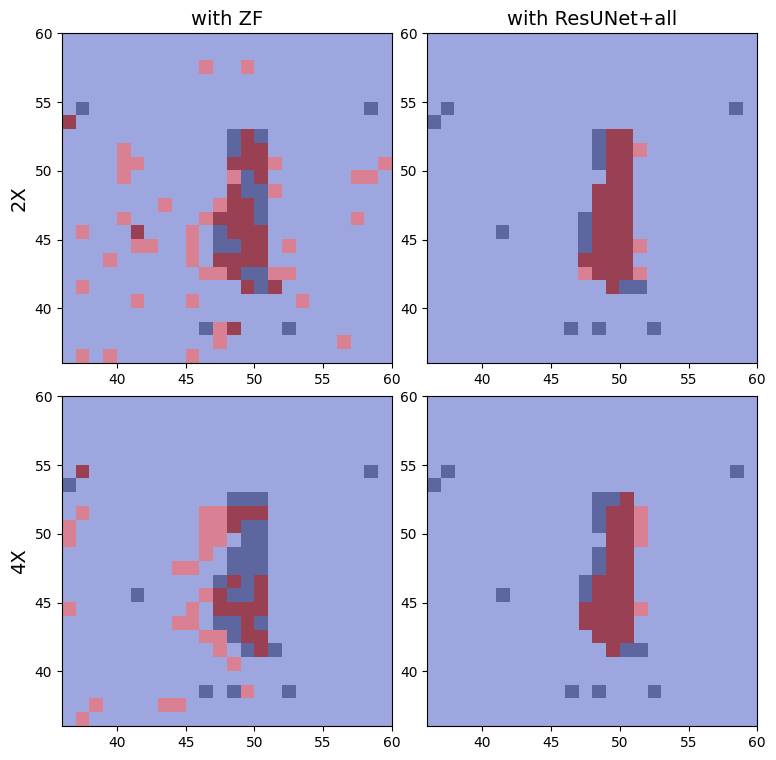

In [10]:
"""Draw Segmentation Overlap (Run after `Compare Drawing Invivo ResUNet (Version 3)`)"""

import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from fastmrt.data.mask import EquiSpacedMaskFunc

fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1])

x_offset, y_offset = 12, 12


for row_idx, row in enumerate(row_orders):
    seg_patches = {}
    for col_idx, col in enumerate(col_orders):

        # obtain seg patches
        patch = datas[row][col]["recon_tmap"][48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset]
        seg_patch = (patch > 43).astype(np.int8)
        seg_patches.update({col: seg_patch})

    # calc overlap
    overlap1 = np.zeros_like(seg_patch, dtype=float)
    overlap2 = np.zeros_like(seg_patch, dtype=float)

    overlap1[(seg_patches["full"] > 0) & (seg_patches["zf"] > 0)] = 1
    overlap2[(seg_patches["full"] > 0) & (seg_patches["resunet_mim"] > 0)] = 1

    # draw
    ax1 = fig.add_subplot(gs[row_idx, 0])
    ax2 = fig.add_subplot(gs[row_idx, 1])

    ax1.imshow(seg_patches["full"], cmap='binary', alpha=0.5, extent=[48-x_offset, 48+x_offset, 48-y_offset, 48+y_offset])
    ax2.imshow(seg_patches["full"], cmap='binary', alpha=0.5, extent=[48-x_offset, 48+x_offset, 48-y_offset, 48+y_offset])

    ax1.imshow(seg_patches["zf"], cmap='coolwarm', alpha=0.5, extent=[48-x_offset, 48+x_offset, 48-y_offset, 48+y_offset])
    ax2.imshow(seg_patches["resunet_mim"], cmap='coolwarm', alpha=0.5, extent=[48-x_offset, 48+x_offset, 48-y_offset, 48+y_offset])

    # ax1.imshow(datas[row][col]["recon_tmap"][48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset], cmap='Pastel1', alpha=0.5)
    # ax2.imshow(datas[row][col]["recon_tmap"][48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset], cmap='Pastel1', alpha=0.5)
    
    # clear ticks
    ax1.set_xlim([48-x_offset, 48+x_offset])
    ax1.set_ylim([48-y_offset, 48+y_offset])
    ax2.set_xlim([48-x_offset, 48+x_offset])
    ax2.set_ylim([48-y_offset, 48+y_offset])

    if row_idx == 0:
        ax1.set_title("with ZF", fontsize=14)
        ax2.set_title("with ResUNet+all", fontsize=14)
        ax1.set_ylabel("2X", fontsize=14)
    else:
        ax1.set_ylabel("4X", fontsize=14)
        
plt.show()

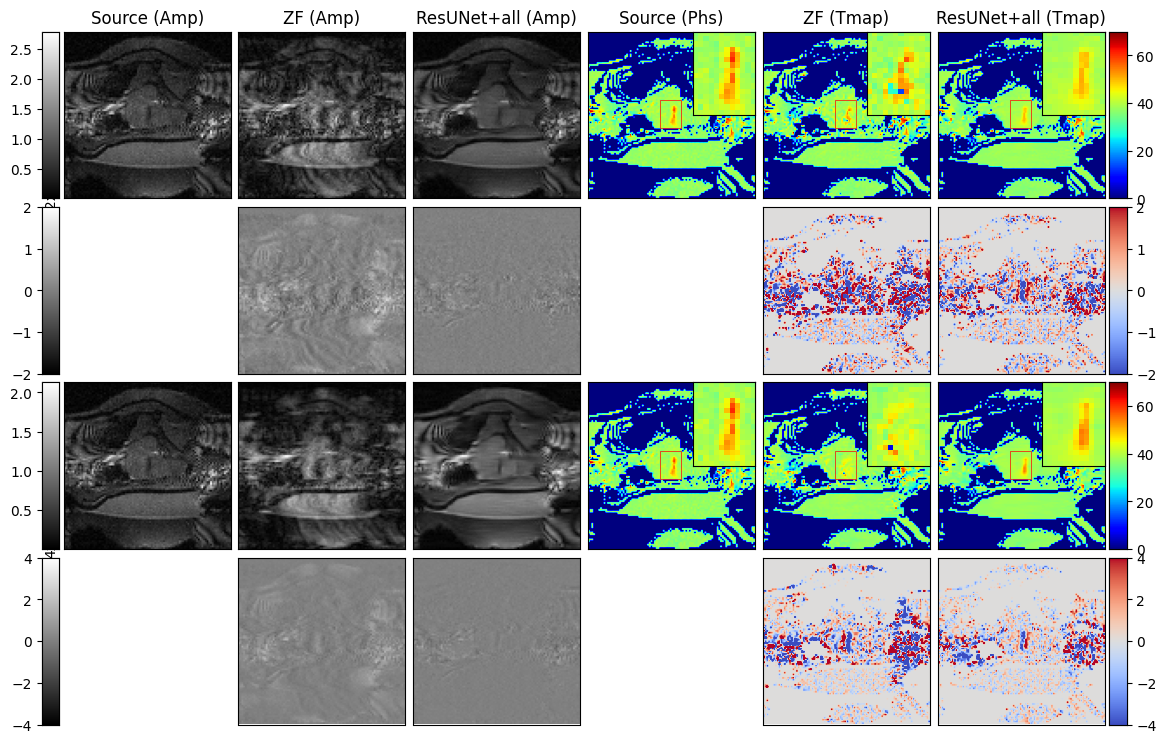

In [11]:
"""Compare Drawing Invivo ResUNet (Version 2)"""

import os
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from fastmrt.data.mask import EquiSpacedMaskFunc

dataset_types = {"invivo": "FastMRT Dataset V5.0_invivo"}
samples = {"invivo": "t13025.h5"}
frame_names = {"invivo": ["f08s0c0", "f08s0c0"]}
datas = {}
x_offset, y_offset, rate = 6, 8, 3


# obtain temperature maps
for key, val in roots.items():
    sub_data = {}
    dataset = key.split("_")[0]
    if dataset == "exvivo" or dataset == "phantom":
        continue
    for k, v in val.items():
        file_dir = os.path.join(v, f"{dataset_types[dataset]}_test_{samples[dataset]}_{frame_names[dataset][0]}")
        if os.path.exists(file_dir) is False:
            file_dir = os.path.join(v, f"{dataset_types[dataset]}_test_{samples[dataset]}_{frame_names[dataset][1]}")
        full_tmap = np.load(os.path.join(file_dir, "full_tmap.npy"))
        recon_tmap = np.load(os.path.join(file_dir, "recon_tmap.npy"))
        label = np.load(os.path.join(file_dir, "label.npy"))
        output = np.load(os.path.join(file_dir, "output.npy"))
        sub_data.update({k: {
                "full_tmap": full_tmap,
                "recon_tmap": recon_tmap,
                "label": label,
                "output": output,
                "patch_output_amp": np.abs(output)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_output_phs": np.angle(output)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_recon_tmap": recon_tmap[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset]
            }})
        sub_data.update({
            "full": {
                "full_tmap": full_tmap,
                "recon_tmap": full_tmap,
                "label": label,
                "output": label,
                "patch_output_amp": np.abs(label)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_output_phs": np.angle(label)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_recon_tmap": full_tmap[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset]
            }
    })
    datas.update({key: sub_data})

# obbatin masks and source data
mask_fn2 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=2)
mask_fn4 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=4)
mask2, _ = mask_fn2([96, 96])
mask4, _ = mask_fn4([96, 96])
masks = {"2x": np.ones([96, 96]) * mask2, "4x": np.ones([96, 96]) * mask4}

# draw
fig = plt.figure(figsize=(14, 9))
fig.subplots_adjust(wspace=0.01, hspace=0.05)
gs = GridSpec(4, 8, figure=fig, width_ratios=[0.1, 1, 1, 1, 1, 1, 1, 0.1], height_ratios=[1, 1, 1, 1])
vmins = [-2, -4]
vmaxs = [2, 4]
# fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(16+1, 16))


row_orders = ["invivo_2x", "invivo_4x"]
col_orders = ["",  "full", "zf", "resunet_mim", "full", "zf", "resunet_mim", ""]
row_names = {
    "invivo_2x": "2x", 
    "invivo_4x": "4x", 
}
title_names = {
    "full": "Source", 
    "zf": "ZF", 
    "resunet_mim": "ResUNet+all",
}
postfix_names = ["",  " (Amp)", " (Amp)", " (Amp)", " (Phs)", " (Tmap)", " (Tmap)", ""]
for row_idx, row in enumerate(row_orders):
    for col_idx, col in enumerate(col_orders):
        ax1 = fig.add_subplot(gs[row_idx * 2, col_idx])
        ax2 = fig.add_subplot(gs[row_idx * 2+1, col_idx])
        if row_idx == 0 and col_idx != 0 and col_idx != 7:
            ax1.set_title(f"{title_names[col_orders[col_idx]]}{postfix_names[col_idx]}")
        # amplitude
        if col_idx == 1 or col_idx == 2 or col_idx == 3:
            err = np.abs(datas[row][col]["label"]) - np.abs(datas[row][col]["output"])
            im1 = ax1.imshow(np.abs(datas[row][col]["output"]), cmap="gray")
            if col_idx != 1:
                im2 = ax2.imshow(err, vmin=vmins[row_idx], vmax=vmaxs[row_idx], cmap="gray")
            else:
                ax1.set_ylabel(row_names[row_orders[row_idx]], y=-0)
                ax2.axis("off")
        # temperature maps
        elif col_idx == 4 or col_idx == 5 or col_idx == 6:
            axins = ax1.inset_axes([(96- 2 * x_offset * rate) / 96, (96 - 2 * y_offset * rate) / 96, 
                                (2 * x_offset * rate) / 96, (2 * y_offset * rate) / 96])
            err = datas[row][col]["recon_tmap"] - datas[row][col]["full_tmap"]
            im1 = ax1.imshow(datas[row][col]["recon_tmap"], vmin=0, vmax=70, cmap="jet")
            if col_idx != 4:
                im2 = ax2.imshow(err, vmin=vmins[row_idx], vmax=vmaxs[row_idx], cmap="coolwarm")
            else:
                ax2.axis("off")
            axins.imshow(datas[row][col]["patch_recon_tmap"], vmin=0, vmax=70, cmap="jet")
            ax1.add_patch(patches.Rectangle((48 - x_offset-1, 48 - y_offset-1), 2*x_offset, 2*y_offset, linewidth=0.5, edgecolor='r', facecolor='none'))
        # ax1.colorbar()
        # ax2.colorbar()
            
        # clear ticks
        axins.set_xticks([])
        axins.set_yticks([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        if col_idx == 3 or col_idx == 7:
            if col_idx == 3:
                col_idx = 0
            cax1 = fig.add_subplot(gs[row_idx * 2, col_idx])
            cax2 = fig.add_subplot(gs[row_idx * 2+1, col_idx])
            if col_idx == 0:
                cbar1 = plt.colorbar(im1, cax=cax1, location='left')
                cbar1.ax.yaxis.set_ticks_position('left')
                cbar2 = plt.colorbar(im2, cax=cax2, location='left')
                cbar2.ax.yaxis.set_ticks_position('left')
            else:
                cbar1 = plt.colorbar(im1, cax=cax1)
                cbar2 = plt.colorbar(im2, cax=cax2)

plt.show()

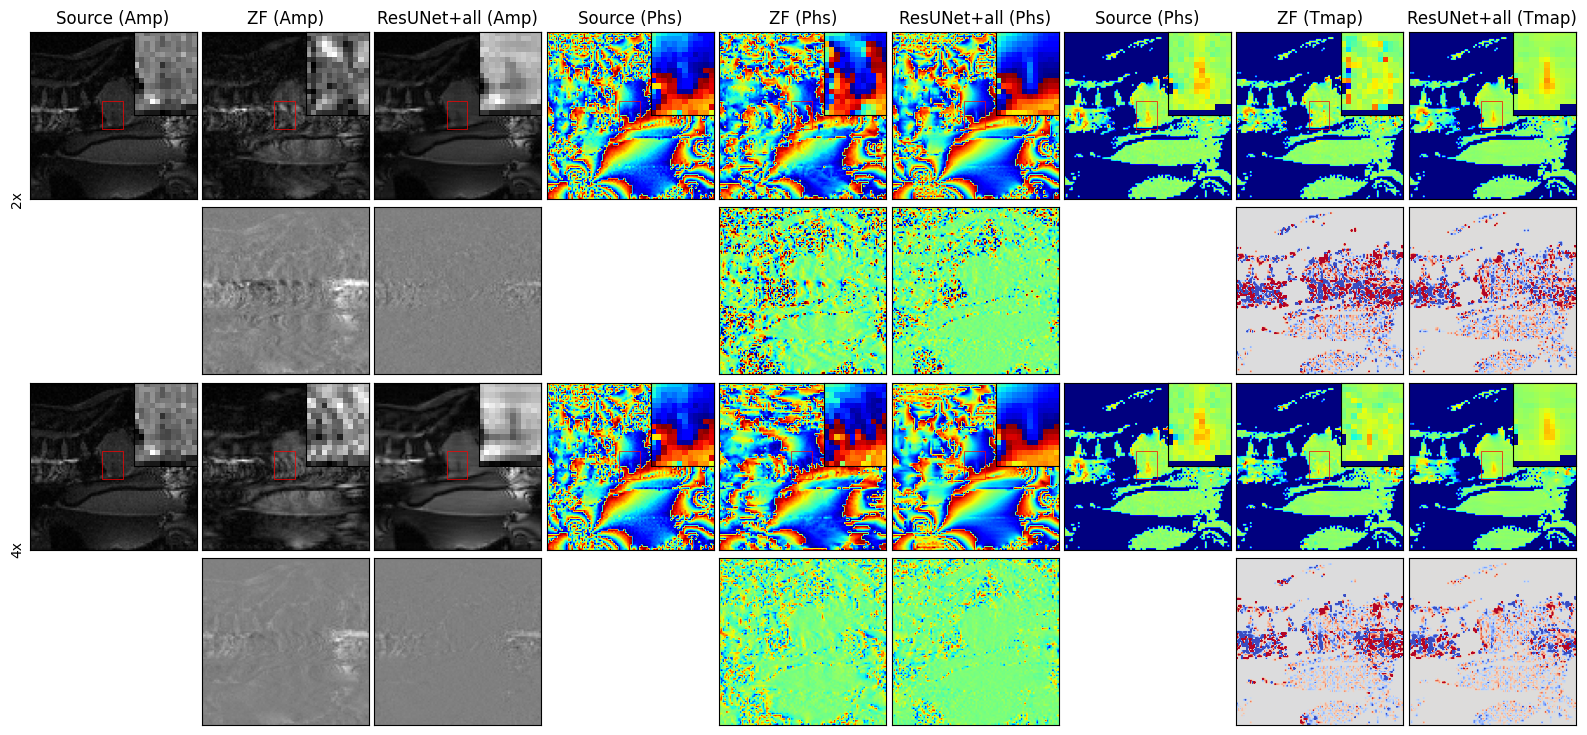

In [12]:
"""Compare Drawing Invivo ResUNet (Version 1)"""

import os
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from fastmrt.data.mask import EquiSpacedMaskFunc

dataset_types = {"invivo": "FastMRT Dataset V5.0_invivo"}
samples = {"invivo": "t13002.h5"}
frame_names = {"invivo": ["f07s0c0", "f07s0c0"]}
datas = {}
x_offset, y_offset, rate = 6, 8, 3


# obtain temperature maps
for key, val in roots.items():
    sub_data = {}
    dataset = key.split("_")[0]
    if dataset == "exvivo" or dataset == "phantom":
        continue
    for k, v in val.items():
        file_dir = os.path.join(v, f"{dataset_types[dataset]}_test_{samples[dataset]}_{frame_names[dataset][0]}")
        if os.path.exists(file_dir) is False:
            file_dir = os.path.join(v, f"{dataset_types[dataset]}_test_{samples[dataset]}_{frame_names[dataset][1]}")
        full_tmap = np.load(os.path.join(file_dir, "full_tmap.npy"))
        recon_tmap = np.load(os.path.join(file_dir, "recon_tmap.npy"))
        label = np.load(os.path.join(file_dir, "label.npy"))
        output = np.load(os.path.join(file_dir, "output.npy"))
        sub_data.update({k: {
                "full_tmap": full_tmap,
                "recon_tmap": recon_tmap,
                "label": label,
                "output": output,
                "patch_output_amp": np.abs(output)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_output_phs": np.angle(output)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_recon_tmap": recon_tmap[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset]
            }})
        sub_data.update({
            "full": {
                "full_tmap": full_tmap,
                "recon_tmap": full_tmap,
                "label": label,
                "output": label,
                "patch_output_amp": np.abs(label)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_output_phs": np.angle(label)[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset],
                "patch_recon_tmap": full_tmap[48 - y_offset : 48 + y_offset, 48 - x_offset : 48 + x_offset]
            }
    })
    datas.update({key: sub_data})

# obbatin masks and source data
mask_fn2 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=2)
mask_fn4 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=4)
mask2, _ = mask_fn2([96, 96])
mask4, _ = mask_fn4([96, 96])
masks = {"2x": np.ones([96, 96]) * mask2, "4x": np.ones([96, 96]) * mask4}

# draw
fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(wspace=0.01, hspace=0.05)
gs = GridSpec(4, 9, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
vmins = [-2, -4]
vmaxs = [2, 4]
# fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(16+1, 16))


row_orders = ["invivo_2x", "invivo_4x"]
col_orders = ["full", "zf", "resunet_mim", "full", "zf", "resunet_mim", "full", "zf", "resunet_mim"]
row_names = {
    "invivo_2x": "2x", 
    "invivo_4x": "4x", 
}
title_names = {
    "full": "Source", 
    "zf": "ZF", 
    "resunet_mim": "ResUNet+all",
}
postfix_names = [" (Amp)", " (Amp)", " (Amp)", " (Phs)", " (Phs)", " (Phs)", " (Phs)", " (Tmap)", " (Tmap)"]
for row_idx, row in enumerate(row_orders):
    for col_idx, col in enumerate(col_orders):
        ax1 = fig.add_subplot(gs[row_idx * 2, col_idx])
        ax2 = fig.add_subplot(gs[row_idx * 2+1, col_idx])
        axins = ax1.inset_axes([(96- 2 * x_offset * rate) / 96, (96 - 2 * y_offset * rate) / 96, 
                                (2 * x_offset * rate) / 96, (2 * y_offset * rate) / 96])
        if row_idx == 0:
            ax1.set_title(f"{title_names[col_orders[col_idx]]}{postfix_names[col_idx]}")
        # amplitude
        if col_idx == 1 or col_idx == 2 or col_idx == 0:
            err = np.abs(datas[row][col]["label"]) - np.abs(datas[row][col]["output"])
            im1 = ax1.imshow(np.abs(datas[row][col]["output"]), cmap="gray")
            if col_idx != 0:
                im2 = ax2.imshow(err, vmin=vmins[row_idx], vmax=vmaxs[row_idx], cmap="gray")
            else:
                ax1.set_ylabel(row_names[row_orders[row_idx]], y=-0)
                ax2.axis("off")
            axins.imshow(datas[row][col]["patch_output_amp"], cmap="gray")
        # phase
        elif col_idx == 3 or col_idx == 4 or col_idx == 5:
            err = np.angle(datas[row][col]["label"] * np.conj(datas[row][col]["output"]))
            im1 = ax1.imshow(np.angle(datas[row][col]["output"]), cmap="jet")
            if col_idx != 3:
                im2 = ax2.imshow(err, vmin=vmins[row_idx], vmax=vmaxs[row_idx], cmap="jet")
            else:
                ax2.axis("off")
            axins.imshow(datas[row][col]["patch_output_phs"], cmap="jet")
        # temperature maps
        else:
            err = datas[row][col]["recon_tmap"] - datas[row][col]["full_tmap"]
            im1 = ax1.imshow(datas[row][col]["recon_tmap"], vmin=0, vmax=70, cmap="jet")
            if col_idx != 6:
                im2 = ax2.imshow(err, vmin=vmins[row_idx], vmax=vmaxs[row_idx], cmap="coolwarm")
            else:
                ax2.axis("off")
            axins.imshow(datas[row][col]["patch_recon_tmap"], vmin=0, vmax=70, cmap="jet")
        ax1.add_patch(patches.Rectangle((48 - x_offset-1, 48 - y_offset-1), 2*x_offset, 2*y_offset, linewidth=0.5, edgecolor='r', facecolor='none'))
        # ax1.colorbar()
        # ax2.colorbar()
            
        # clear ticks
        axins.set_xticks([])
        axins.set_yticks([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])

    # cax1 = fig.add_subplot(gs[row_idx * 2, -1])
    # cax2 = fig.add_subplot(gs[row_idx * 2+1, -1])
    # cbar1 = plt.colorbar(im1, cax=cax1)
    # cbar2 = plt.colorbar(im2, cax=cax2)